In [1]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import warnings
import math
warnings.filterwarnings("ignore")
import boto3
from time import sleep
from lightfm import LightFM, data,cross_validation, evaluation
import seaborn as sns
import pickle
import numpy.matlib
import pprint
import tqdm
from multiprocessing.dummy import Pool as ThreadPool
from itertools import repeat
import random
from typing import List
import functools
from sklearn.neighbors import NearestNeighbors
from typing import List
import functools
import pynndescent
from recommender import Recommender
import multiprocessing
import utils
import matplotlib.pyplot as plt

In [2]:
#number of unique users
N_USERS = 100000
#minimum number of devices on which the app needs to be installed to be considered in the training
N_DEVICES = 500
#number of latent factors for the recommendation model
N_LATENT_FACTORS=30
#number of recommendation model training epochs
N_EPOCHS = 10
#number of threads for parallel processing
N_THREADS = multiprocessing.cpu_count() # or os.cpu_count()
#organizations selected
ORGS = ['entel', 'claroco', 'tim brasil', 'vivo', 'telefonica peru', 'claro br', 'claro ecuador']

In [3]:
pool = ThreadPool(N_THREADS)
boto3_session = boto3.Session()
s3_client = boto3_session.client('s3')
bucket = 'dr-campaign-optimization'

<h3> Load Data </h3>

In [5]:
def get_data_from_athena(query,athena_querier=None,retries=1):
    """
    TODO: divide this method in 2: sending query to querier and then reading results
       queries athena for the data needed. Will create the raw_data and column_index attributes
        Inputs: depends on the 
        Outputs:          
    """
    if athena_querier is None:
        athena_querier = utils.AthenaQuerier()

    query_state = None
    while (query_state != "SUCCEEDED" and retries>0):
        query_id = athena_querier.start_acadia_query_execution(query)
        queries_dict = athena_querier.wait_for_queries_completion(backoff_rate=1.2)    
        query_state = queries_dict[query_id]
        retries-=1
        if query_state != "SUCCEEDED":
            sleep(10)

    if query_state != "SUCCEEDED":
            raise NotImplementedError(
                "Max retries reached and query state at {}, handling not yet implemented".format(query_state)
            )
    else:
        raw_data = utils.read_from_s3(
        pd.read_csv,
        utils.ATHENA_OUTPUT_LOCATION["bucket"],
        utils.ATHENA_OUTPUT_LOCATION["directory"] + query_id + ".csv",
        s3_client,
    )
        return raw_data
    
def load_training_data(orgs, max_len, is_local=False):
    if isinstance(orgs, str):
        orgs=f"('{orgs}')"
    elif isinstance(orgs, list):
        orgs=tuple(orgs)
        
    if is_local:
      df = pd.read_csv('df_installedapps.csv')[['clientid', 'appname', 'devicemodel', 'org']].drop_duplicates()
      return df
    else:   
        query = f"""
        with devices_recent as (
            select distinct 
                clientid, org, carrier, devicemake, devicemodel, lastactivedate
            from 
                deviceinfo
            where 
                org in {orgs} and clientid in (select distinct(clientid)
                                            from "acadia".installedapps)
            order by lastactivedate desc
            limit {max_len}
        ) 
        select 
            ia.clientid, appname, di.org, ia.org, devicemodel 
        from 
            "acadia"."installedapps" ia join devices_recent di on (ia.clientid = di.clientid)
        """   
        athena_querier = utils.AthenaQuerier()
        q = get_data_from_athena(query, athena_querier=athena_querier)
        df = q[['clientid', 'appname', 'devicemodel', 'org']].drop_duplicates()
    return q

In [5]:
q = load_training_data(ORGS, N_USERS, is_local=False)
df = q[['clientid', 'appname', 'devicemodel', 'org']].drop_duplicates()
print(f'Tamanho da base {df.shape}')
print(f'Número de users: {df.clientid.nunique()}')
print(f'Número de apps: {df.appname.nunique()}')

Starting to wait for queries completion...
Will wait at most 7200 seconds...

Starting wait number 1 at 2022-06-30 18:35:11.938767 for 10 seconds
Finished waiting number 1
Query States:
{'28235f71-4837-41d7-9217-5f47505d48d2': 'RUNNING'}
Starting wait number 2 at 2022-06-30 18:35:22.020147 for 12.0 seconds
Finished waiting number 2
Query States:
{'28235f71-4837-41d7-9217-5f47505d48d2': 'RUNNING'}
Starting wait number 3 at 2022-06-30 18:35:34.100453 for 14.399999999999999 seconds
Finished waiting number 3
Query States:
{'28235f71-4837-41d7-9217-5f47505d48d2': 'RUNNING'}
Starting wait number 4 at 2022-06-30 18:35:48.582279 for 17.279999999999998 seconds
Finished waiting number 4
Query States:
{'28235f71-4837-41d7-9217-5f47505d48d2': 'SUCCEEDED'}
Tamanho da base (4963478, 4)
Número de users: 99959
Número de apps: 114966


In [6]:
q1 = sum(df.appname.value_counts().reset_index().appname<=6)/df.appname.nunique()
print(f'{round(q1*100,2)}% of apps is installed on 6 or less devices.')

81.34% dos apps está instalado em 6 ou menos devices.


In [7]:
n_users_app = df.appname.value_counts().reset_index()
n_users_app['%total'] = n_users_app.appname/df.clientid.nunique()
n_users_app.columns = ['app', 'n_users', '%total']

n_devices = 1000
q2 = sum(n_users_app.n_users>=n_devices)
print(f'The number of apps installed on more than {n_devices} devices is {q2}.')
relevant_apps = list(n_users_app[n_users_app.n_users>=n_devices].app)

O número de apps instalado em mais de 1000 devices é de 595.


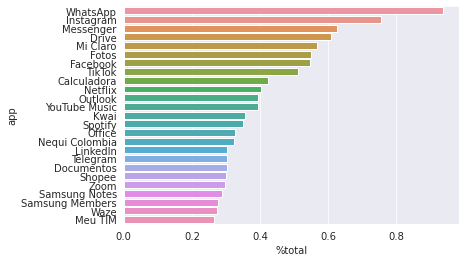

In [8]:
sns.set_style('darkgrid')
x = 'app'
y = '%total'
sns.barplot(y, x, data = n_users_app.head(25));

<h3> Masking </h3>

In [9]:
clients_ids_test = np.random.choice(df.clientid.unique(), int(len(df.clientid.unique())*.05))
#apply filter. Select only the most relevant apps. Select only clients for training
df_train = df[df.appname.isin(relevant_apps)][~df.clientid.isin(clients_ids_test)]

In [10]:
df_test = df[df.appname.isin(relevant_apps)][df.clientid.isin(clients_ids_test)]

In [11]:
df_masked = df_train.groupby('clientid', group_keys=False).apply(lambda x: x.sample(frac=.2))
#df_test = df_test[df_test.masked]
apps_masked = df_masked.groupby('clientid')['appname'].apply(list)
df_unmasked = df_train.copy()
#df_train.loc[df_test.index, :] = df_test.replace({'installed': {1:0}})[:]
df_unmasked = df_unmasked.drop(df_masked.index)

<h3> Building sparse matrix </h3>

In [12]:
matrix = data.Dataset()
matrix.fit(users=list(df_train.clientid.unique()), items=list(df_train.appname.unique()), 
                     user_features=list(df_train.devicemodel.unique()))
interactions_unmasked = matrix.build_interactions(data=[[row[1], row[2]] for row in df_unmasked[['clientid', 'appname']].itertuples()])
interactions_masked = matrix.build_interactions(data=[[row[1], row[2]] for row in df_masked[['clientid', 'appname']].itertuples()])
user_features = matrix.build_user_features([[row[1], [row[2]]] for row in df_train[['clientid', 'devicemodel']].drop_duplicates().itertuples()], normalize=False)

<h3> Training </h3>

In [13]:
model_lightfm_warp = LightFM(no_components=30, learning_rate=0.05, loss='warp')
model_lightfm_warp.fit(interactions_unmasked[0], epochs=10, verbose=True, num_threads=N_THREADS)

model_lightfm_bpr = LightFM(no_components=30, learning_rate=0.05, loss='bpr')
model_lightfm_bpr.fit(interactions_unmasked[0], epochs=10, verbose=True, num_threads=N_THREADS)

model_lightfm_warpkos = LightFM(no_components=30, learning_rate=0.05, loss='warp-kos', k=5)
model_lightfm_warpkos.fit(interactions_unmasked[0], epochs=10, verbose=True, num_threads=N_THREADS)

Epoch: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


In [14]:
nbrs_training = pynndescent.NNDescent(interactions_unmasked[0].tocsr(), metric="cosine", n_jobs=N_THREADS, verbose=True)

Thu Jun 30 18:37:47 2022 Building RP forest with 23 trees
Thu Jun 30 18:38:03 2022 metric NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	Stopping threshold met -- exiting after 7 iterations


<h3> Evaluation </h3>

Discounted Cumulative Gain 
$$DCG = \sum_{k=1}^{n}\frac{2^{y_{k}}-1}{log_{2}(k+1)}$$

<ul>
    <li>recommender system precision = $\frac{\textrm{# of our recommendation that are relevant}}{\textrm{# of itens we recommended}}$</li>
    <li>recommender system recall = $\frac{\textrm{# of our recommendations that are relevant}}{\textrm{# of all the possible relevant items}}$</li>
</ul>
$$ MAP@N = \frac{1}{|U|}\sum_{u\in U}{\frac{1}{m}\sum_{k=1}^{N}{P_{u}(k)rel_{u}(k)}} $$

In [15]:
mapping = matrix.mapping()
rec = Recommender(mapping, interactions_unmasked[0], relevant_apps, interactions_masked[0])

In [16]:
%%time
dict_evaluation = rec.evaluation_model([model_lightfm_warp, model_lightfm_bpr, model_lightfm_warpkos], ['LightFM_warp', 'LightFM_bpr', 'LightFM_warpkos'],
                                       n_sample=40000, use_baseline=True)

100%|██████████| 40000/40000 [00:08<00:00, 4499.18it/s]


CPU times: user 17min 11s, sys: 1.8 s, total: 17min 13s
Wall time: 2min 27s


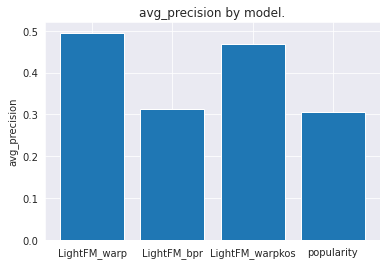

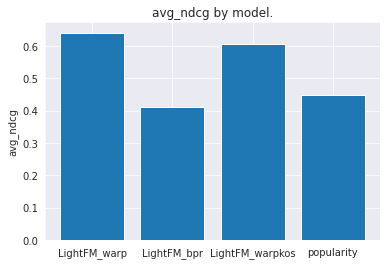

In [17]:
for k,v in zip(dict_evaluation.keys(), dict_evaluation.values()):
    plt.bar(*zip(*v.items()))
    plt.ylabel(f'{k}')
    plt.title(f'{k} by model.')
    plt.show()

In [18]:
precision_by_k = rec.evaluating_precision_model_by_k([model_lightfm_warp, model_lightfm_bpr, model_lightfm_warpkos], ['LightFM_warp', 'LightFM_bpr', 'LightFM_warpkos'],
                                       n_sample=10000, k_max=10, baselines=['popularity'])

100%|██████████| 10000/10000 [00:00<00:00, 39234.93it/s]


In [19]:
precision_by_k
precision_by_k.index.name = 'k'
precision_by_k

,LightFM_warp,LightFM_bpr,LightFM_warpkos,popularity
k,,,,
2,0.580297,0.393673,0.547478,0.365865
3,0.552594,0.354091,0.524890,0.328988
4,0.532097,0.327313,0.508016,0.310038
5,0.521343,0.310286,0.495719,0.298275
6,0.511435,0.297180,0.484524,0.290288
7,0.500772,0.284788,0.472578,0.280638
8,0.491416,0.273994,0.465746,0.273195
9,0.483772,0.264510,0.456283,0.271432
10,0.477626,0.260700,0.451232,0.272892


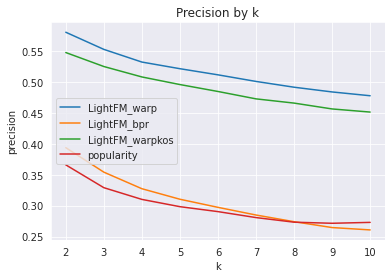

In [20]:
precision_by_k.plot.line(xlabel='k', ylabel='precision', title='Precision by k');

<h3> Comparing precision between similarity-based  and popularity-based recommendation</h3>

In [21]:
df_t = df_test

In [22]:
s = df_t.groupby('clientid').appname.count()
df_t = df_t[df_t.clientid.isin(s[s > 5].index.tolist())]

In [23]:
df_test_masked = df_t.groupby('clientid', group_keys=False).apply(lambda x: x.sample(frac=.2))
apps_test_masked = df_test_masked.groupby('clientid')['appname'].apply(list)
df_test_unmasked = df_t.copy()
df_test_unmasked = df_test_unmasked.drop(df_test_masked.index)

In [24]:
Apps_list = np.array(df_test_unmasked.groupby('clientid').appname.apply(list))

In [25]:
import time
start_time = time.time()
dfs = rec.predict_similarity_based(nbrs_training, model_lightfm_warp, Apps_list)
t1 = time.time() - start_time
print("--- %s seconds ---" % (t1))

Thu Jun 30 18:43:23 2022 Worst tree score: 0.31709421
Thu Jun 30 18:43:23 2022 Mean tree score: 0.33845951
Thu Jun 30 18:43:23 2022 Best tree score: 0.35362173
Thu Jun 30 18:43:33 2022 Forward diversification reduced edges from 2852370 to 905238
Thu Jun 30 18:43:38 2022 Reverse diversification reduced edges from 905238 to 905238
Thu Jun 30 18:43:41 2022 Degree pruning reduced edges from 1253746 to 1246195
Thu Jun 30 18:43:41 2022 Resorting data and graph based on tree order
Thu Jun 30 18:43:41 2022 Building and compiling sparse search function


100%|██████████| 23965/23965 [00:11<00:00, 1999.61it/s]


--- 45.41772532463074 seconds ---


In [26]:
print(f'Time for user: {round(t1/len(Apps_list),4)} seconds')

Time for user: 0.0095 seconds


In [27]:
import time
start_time = time.time()
dfp = rec.predict_baseline(users_apps = Apps_list, baseline ='popularity')
t2 = time.time() - start_time
print("--- %s seconds ---" % (t2))

--- 0.5594751834869385 seconds ---


In [28]:
print(f'Time for user: {round(t2/len(Apps_list),4)} seconds')

Time for user: 0.0001 seconds


In [29]:
sim_precision = []
pop_precision = []
for i in range(len(dfs)):
    sim_tops = dfs.iloc[i,:].sort_values(ascending=False).index
    pop_tops =  dfp.iloc[i,:].sort_values(ascending=False).index
    actual = apps_test_masked[i]
    sim_precision.append(rec._score(sim_tops, actual, 'precision'))
    pop_precision.append(rec._score(pop_tops, actual, 'precision'))

In [30]:
print(f'Average precision for similarity based model: {round(np.mean(sim_precision),2)}')
print(f'Average precision for poularity based model: {round(np.mean(pop_precision),2)}')

Average precision for similarity based model: 0.54
Average precision for poularity based model: 0.3


<h3> Evaluation by organization </h3>

In [6]:
precision_by_org = {}
for org in ORGS:
    print(f'-----------------------LOAD AND PREPARATION-{org}-----------------------')
    q = load_training_data(org, N_USERS, is_local=False)
    df = q[['clientid', 'appname', 'devicemodel', 'org']].drop_duplicates()
    n_users_app = df.appname.value_counts().reset_index()
    n_users_app['%total'] = n_users_app.appname/df.clientid.nunique()
    n_users_app.columns = ['app', 'n_users', '%total']
    n_devices = 1000 
    q2 = sum(n_users_app.n_users>=n_devices)
    print(f'O número de apps instalado em mais de {n_devices} devices é de {q2}.')
    relevant_apps = list(n_users_app[n_users_app.n_users>=n_devices].app)
    print(f'----------------------MASKING-{org}---------------------------------------')
    clients_ids_test = np.random.choice(df.clientid.unique(), int(len(df.clientid.unique())*.05))
    #apply filter. Select only the most relevant apps. Select only clients for training
    df_train = df[df.appname.isin(relevant_apps)][~df.clientid.isin(clients_ids_test)]
    df_test = df[df.appname.isin(relevant_apps)][df.clientid.isin(clients_ids_test)]
    df_masked = df_train.groupby('clientid', group_keys=False).apply(lambda x: x.sample(frac=.2))
    #df_test = df_test[df_test.masked]
    apps_masked = df_masked.groupby('clientid')['appname'].apply(list)
    df_unmasked = df_train.copy()
    #df_train.loc[df_test.index, :] = df_test.replace({'installed': {1:0}})[:]
    df_unmasked = df_unmasked.drop(df_masked.index)
    print(f'----------------------BUILDING SPARSE MATRIX-{org}---------------------------------------')
    matrix = data.Dataset()
    matrix.fit(users=list(df_train.clientid.unique()), items=list(df_train.appname.unique()), 
                         user_features=list(df_train.devicemodel.unique()))
    interactions_unmasked = matrix.build_interactions(data=[[row[1], row[2]] for row in df_unmasked[['clientid', 'appname']].itertuples()])
    interactions_masked = matrix.build_interactions(data=[[row[1], row[2]] for row in df_masked[['clientid', 'appname']].itertuples()])
    user_features = matrix.build_user_features([[row[1], [row[2]]] for row in df_train[['clientid', 'devicemodel']].drop_duplicates().itertuples()], normalize=False)
    print(f'----------------------TRAINING-{org}---------------------------------------')
    model_lightfm_warp = LightFM(no_components=30, learning_rate=0.05, loss='warp')
    model_lightfm_warp.fit(interactions_unmasked[0], epochs=10, verbose=True, num_threads=N_THREADS)
    print(f'----------------------EVALUATION-{org}---------------------------------------')
    mapping = matrix.mapping()
    rec = Recommender(mapping, interactions_unmasked[0], relevant_apps, interactions_masked[0])
    precision_by_k = rec.evaluating_precision_model_by_k([model_lightfm_warp], ['LightFM_warp'],
                                       n_sample=10000, k_max=10, baselines=['popularity'])
    precision_by_org[org] = precision_by_k['LightFM_warp']

-----------------------LOAD AND PREPARATION-entel-----------------------
Starting to wait for queries completion...
Will wait at most 7200 seconds...

Starting wait number 1 at 2022-06-30 21:02:06.251951 for 10 seconds
Finished waiting number 1
Query States:
{'44a7e402-6bb5-4a9a-8a47-ce819640c56f': 'RUNNING'}
Starting wait number 2 at 2022-06-30 21:02:16.324779 for 12.0 seconds
Finished waiting number 2
Query States:
{'44a7e402-6bb5-4a9a-8a47-ce819640c56f': 'RUNNING'}
Starting wait number 3 at 2022-06-30 21:02:28.409670 for 14.399999999999999 seconds
Finished waiting number 3
Query States:
{'44a7e402-6bb5-4a9a-8a47-ce819640c56f': 'SUCCEEDED'}
O número de apps instalado em mais de 1000 devices é de 245.
----------------------MASKING-entel---------------------------------------
----------------------BUILDING SPARSE MATRIX-entel---------------------------------------
----------------------TRAINING-entel---------------------------------------


Epoch: 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


----------------------EVALUATION-entel---------------------------------------


100%|██████████| 10000/10000 [00:00<00:00, 128103.60it/s]


-----------------------LOAD AND PREPARATION-claroco-----------------------
Starting to wait for queries completion...
Will wait at most 7200 seconds...

Starting wait number 1 at 2022-06-30 21:03:29.266740 for 10 seconds
Finished waiting number 1
Query States:
{'cd4e37fa-472c-4926-8a57-f8d2bf4841e2': 'RUNNING'}
Starting wait number 2 at 2022-06-30 21:03:39.341801 for 12.0 seconds
Finished waiting number 2
Query States:
{'cd4e37fa-472c-4926-8a57-f8d2bf4841e2': 'RUNNING'}
Starting wait number 3 at 2022-06-30 21:03:51.568446 for 14.399999999999999 seconds
Finished waiting number 3
Query States:
{'cd4e37fa-472c-4926-8a57-f8d2bf4841e2': 'SUCCEEDED'}
O número de apps instalado em mais de 1000 devices é de 512.
----------------------MASKING-claroco---------------------------------------
----------------------BUILDING SPARSE MATRIX-claroco---------------------------------------
----------------------TRAINING-claroco---------------------------------------


Epoch: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


----------------------EVALUATION-claroco---------------------------------------


100%|██████████| 10000/10000 [00:00<00:00, 38276.39it/s]


-----------------------LOAD AND PREPARATION-tim brasil-----------------------
Starting to wait for queries completion...
Will wait at most 7200 seconds...

Starting wait number 1 at 2022-06-30 21:05:22.125108 for 10 seconds
Finished waiting number 1
Query States:
{'cd66fb99-23e9-4fca-be15-a2344a743781': 'RUNNING'}
Starting wait number 2 at 2022-06-30 21:05:32.202986 for 12.0 seconds
Finished waiting number 2
Query States:
{'cd66fb99-23e9-4fca-be15-a2344a743781': 'RUNNING'}
Starting wait number 3 at 2022-06-30 21:05:44.284678 for 14.399999999999999 seconds
Finished waiting number 3
Query States:
{'cd66fb99-23e9-4fca-be15-a2344a743781': 'SUCCEEDED'}
O número de apps instalado em mais de 1000 devices é de 551.
----------------------MASKING-tim brasil---------------------------------------
----------------------BUILDING SPARSE MATRIX-tim brasil---------------------------------------
----------------------TRAINING-tim brasil---------------------------------------


Epoch: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


----------------------EVALUATION-tim brasil---------------------------------------


100%|██████████| 10000/10000 [00:00<00:00, 35586.57it/s]


-----------------------LOAD AND PREPARATION-vivo-----------------------
Starting to wait for queries completion...
Will wait at most 7200 seconds...

Starting wait number 1 at 2022-06-30 21:07:17.914321 for 10 seconds
Finished waiting number 1
Query States:
{'b46571a5-ffce-4f4f-a653-231ddf6d4fed': 'RUNNING'}
Starting wait number 2 at 2022-06-30 21:07:27.996499 for 12.0 seconds
Finished waiting number 2
Query States:
{'b46571a5-ffce-4f4f-a653-231ddf6d4fed': 'RUNNING'}
Starting wait number 3 at 2022-06-30 21:07:40.087152 for 14.399999999999999 seconds
Finished waiting number 3
Query States:
{'b46571a5-ffce-4f4f-a653-231ddf6d4fed': 'RUNNING'}
Starting wait number 4 at 2022-06-30 21:07:54.568384 for 17.279999999999998 seconds
Finished waiting number 4
Query States:
{'b46571a5-ffce-4f4f-a653-231ddf6d4fed': 'SUCCEEDED'}
O número de apps instalado em mais de 1000 devices é de 604.
----------------------MASKING-vivo---------------------------------------
----------------------BUILDING SPARSE M

Epoch: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


----------------------EVALUATION-vivo---------------------------------------


100%|██████████| 10000/10000 [00:00<00:00, 33770.65it/s]


-----------------------LOAD AND PREPARATION-telefonica peru-----------------------
Starting to wait for queries completion...
Will wait at most 7200 seconds...

Starting wait number 1 at 2022-06-30 21:09:35.006967 for 10 seconds
Finished waiting number 1
Query States:
{'364f93af-6021-40f9-ab9f-7dcaba9b0a6c': 'RUNNING'}
Starting wait number 2 at 2022-06-30 21:09:45.078757 for 12.0 seconds
Finished waiting number 2
Query States:
{'364f93af-6021-40f9-ab9f-7dcaba9b0a6c': 'SUCCEEDED'}
O número de apps instalado em mais de 1000 devices é de 521.
----------------------MASKING-telefonica peru---------------------------------------
----------------------BUILDING SPARSE MATRIX-telefonica peru---------------------------------------
----------------------TRAINING-telefonica peru---------------------------------------


Epoch: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


----------------------EVALUATION-telefonica peru---------------------------------------


100%|██████████| 10000/10000 [00:00<00:00, 45697.85it/s]


-----------------------LOAD AND PREPARATION-claro br-----------------------
Starting to wait for queries completion...
Will wait at most 7200 seconds...

Starting wait number 1 at 2022-06-30 21:11:09.338043 for 10 seconds
Finished waiting number 1
Query States:
{'961ec471-a1e4-4256-8abd-edb1441cf978': 'RUNNING'}
Starting wait number 2 at 2022-06-30 21:11:19.415058 for 12.0 seconds
Finished waiting number 2
Query States:
{'961ec471-a1e4-4256-8abd-edb1441cf978': 'RUNNING'}
Starting wait number 3 at 2022-06-30 21:11:31.509570 for 14.399999999999999 seconds
Finished waiting number 3
Query States:
{'961ec471-a1e4-4256-8abd-edb1441cf978': 'SUCCEEDED'}
O número de apps instalado em mais de 1000 devices é de 394.
----------------------MASKING-claro br---------------------------------------
----------------------BUILDING SPARSE MATRIX-claro br---------------------------------------
----------------------TRAINING-claro br---------------------------------------


Epoch: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


----------------------EVALUATION-claro br---------------------------------------


100%|██████████| 10000/10000 [00:00<00:00, 66507.21it/s]


-----------------------LOAD AND PREPARATION-claro ecuador-----------------------
Starting to wait for queries completion...
Will wait at most 7200 seconds...

Starting wait number 1 at 2022-06-30 21:12:49.056635 for 10 seconds
Finished waiting number 1
Query States:
{'c241d7ae-1226-46e8-aabd-2d5296c202c1': 'RUNNING'}
Starting wait number 2 at 2022-06-30 21:12:59.138709 for 12.0 seconds
Finished waiting number 2
Query States:
{'c241d7ae-1226-46e8-aabd-2d5296c202c1': 'RUNNING'}
Starting wait number 3 at 2022-06-30 21:13:11.226933 for 14.399999999999999 seconds
Finished waiting number 3
Query States:
{'c241d7ae-1226-46e8-aabd-2d5296c202c1': 'SUCCEEDED'}
O número de apps instalado em mais de 1000 devices é de 411.
----------------------MASKING-claro ecuador---------------------------------------
----------------------BUILDING SPARSE MATRIX-claro ecuador---------------------------------------
----------------------TRAINING-claro ecuador---------------------------------------


Epoch: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


----------------------EVALUATION-claro ecuador---------------------------------------


100%|██████████| 10000/10000 [00:00<00:00, 29639.50it/s]


In [7]:
precision_by_org = pd.DataFrame(precision_by_org)
precision_by_org.index.name = 'k'
precision_by_org

,entel,claroco,tim brasil,vivo,telefonica peru,claro br,claro ecuador
k,,,,,,,
2,0.498160,0.594520,0.567668,0.597704,0.539770,0.513951,0.559258
3,0.488468,0.554545,0.537009,0.569150,0.517197,0.507985,0.541402
4,0.482348,0.528633,0.514047,0.547252,0.502388,0.502750,0.523550
5,0.488903,0.510914,0.495193,0.532373,0.489224,0.500061,0.506898
6,0.481172,0.494732,0.484510,0.519707,0.477053,0.497891,0.491629
7,0.477308,0.484580,0.477930,0.509974,0.468932,0.491219,0.471905
8,0.470588,0.481088,0.473330,0.500604,0.460769,0.482704,0.460542
9,0.459908,0.474408,0.470210,0.489926,0.455606,0.487321,0.447995
10,0.445098,0.469745,0.466557,0.480846,0.446319,0.485410,0.439464


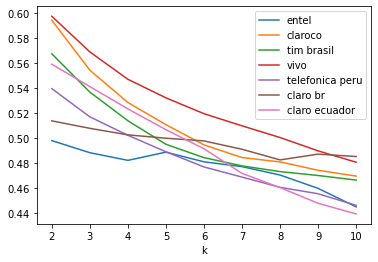

In [9]:
precision_by_org.plot();